In [1]:
import sys
import numpy as np
import scipy
import subprocess
from natsort import natsorted
import itertools
import pandas as pd
sys.path.append("../utls")
sys.path.append("../utls")
sys.path.append("../.")
import os
from preprocessing import *
from InterfaceDeclaration import LPBFInterface
import matplotlib.pyplot as plt
import seaborn as sns

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
process_regime = [
    [0,    59, "Base"  ], 
    [60,  129, "KH"    ], 
    [130, 199, "Normal"], 
    [200, 269, "RLoF"  ], 
    [269, 339, "LoF"   ] 
]

## Trained accuracy

In [138]:
def generate_hist_name(model_name, acoustic_type, context_type,output_type,folds):
    context_combinations = []
    for r in range(len(context_type) + 1): 
        context_combinations.extend(itertools.combinations(context_type, r))

    # Generate all combinations of acoustic_type with context_combinations
    all_combinations = []
    for _output in output_type:
        for model in model_name:
            for acoustic in acoustic_type:
                for context in context_combinations:
                    if len(context)>0:
                        inputs = {acoustic}+{'+'.join(list(context))}
                        all_combinations.append(f"{model}_classification_input_{acoustic}+{'+'.join(list(context))}_output_{_output}")
                    else:
                        inputs = {acoustic}
                        all_combinations.append(f"{model}_classification_input_{acoustic}_output_{_output}")
                    
                    
                    #     all_combinations.append(f"{model}_classification_input_{acoustic}")
    return all_combinations

def find_non_float_index(lst):
    for i, item in enumerate(lst):
        try:
            float(item)
        except TypeError:
            return i
    return -1 

def get_hist_data(hist_dir, model_name,inputs,output_type,folds):
    train_acc = []
    test_acc = []
    for i in range(folds):
        file_path = f"{model_name}_classification_input_{inputs}_output_{output_type}_roi_time10_roi_radius3_fold{i}_of_folds10.csv"
        file_path = os.path.join(hist_dir,file_path)
        df = pd.read_csv(file_path,index_col=0)
        df = df[~df.index.get_level_values(0).duplicated(keep='last')]
        train_acc.append((df['Train Accuracy'][100]))
        test_acc.append((df['Test Accuracy'][100]))
    return train_acc,test_acc

def get_hist_data_path(hist_dir, model_name,inputs,output_type,fold=0):
    file_path = f"{model_name}_classification_input_{inputs}_output_{output_type}_roi_time10_roi_radius3_fold{fold}_of_folds10.csv"
    file_path = os.path.join(hist_dir,file_path)
    return file_path

def generate_hist_df(hist_dir,model_name, acoustic_type, context_type,output_type,folds):
    context_combinations = []
    for r in range(len(context_type) + 1): 
        context_combinations.extend(itertools.combinations(context_type, r))
    train_acc_list = []
    test_acc_list = []
    fold_i_list = []
    inputs_list = []
    outputs_list = []
    model_list = []

    for _output in output_type:
        for model in model_name:
            for acoustic in acoustic_type:
                for context in context_combinations:
                    if len(context)>0:
                        inputs = f"{acoustic}+{'+'.join(list(context))}"
                    else:
                        inputs = acoustic

                    train_acc,test_acc = get_hist_data(hist_dir,model,inputs,_output,folds)
                    for i in range(folds):
                        fold_i_list.append(i)
                        train_acc_list.append(train_acc[i])
                        test_acc_list.append(test_acc[i])
                        inputs_list.append(inputs)
                        outputs_list.append(_output)
                        model_list.append(model)
    df = pd.DataFrame()
    df['Model'] = model_list
    df['Train Acc'] = train_acc_list
    df['Test Acc']  = test_acc_list
    df['Fold index'] = fold_i_list
    df['Input type'] = inputs_list
    df['Output type'] = outputs_list

    new_df = pd.concat([df,df])
    new_df['Acc'] = pd.concat([df['Train Acc'], df['Test Acc']])
    new_df['Acc type']= ['Train'] * len(df) + ['Test'] * len(df)
    new_df.index = range(len(new_df))
    return new_df

In [161]:
his_dir = os.path.join(os.pardir,"lfs","weights/hist")
model_name= ["CNN","SVM"]
acoustic_type =['ae','mic'] 
context_type = ['energy','direction','position']
output_type = ['regime']
folds = 10

df = generate_hist_df(his_dir,model_name,acoustic_type,context_type,output_type,folds)
df['Input Type'] = df['Input type'].str.replace('+', '\n')

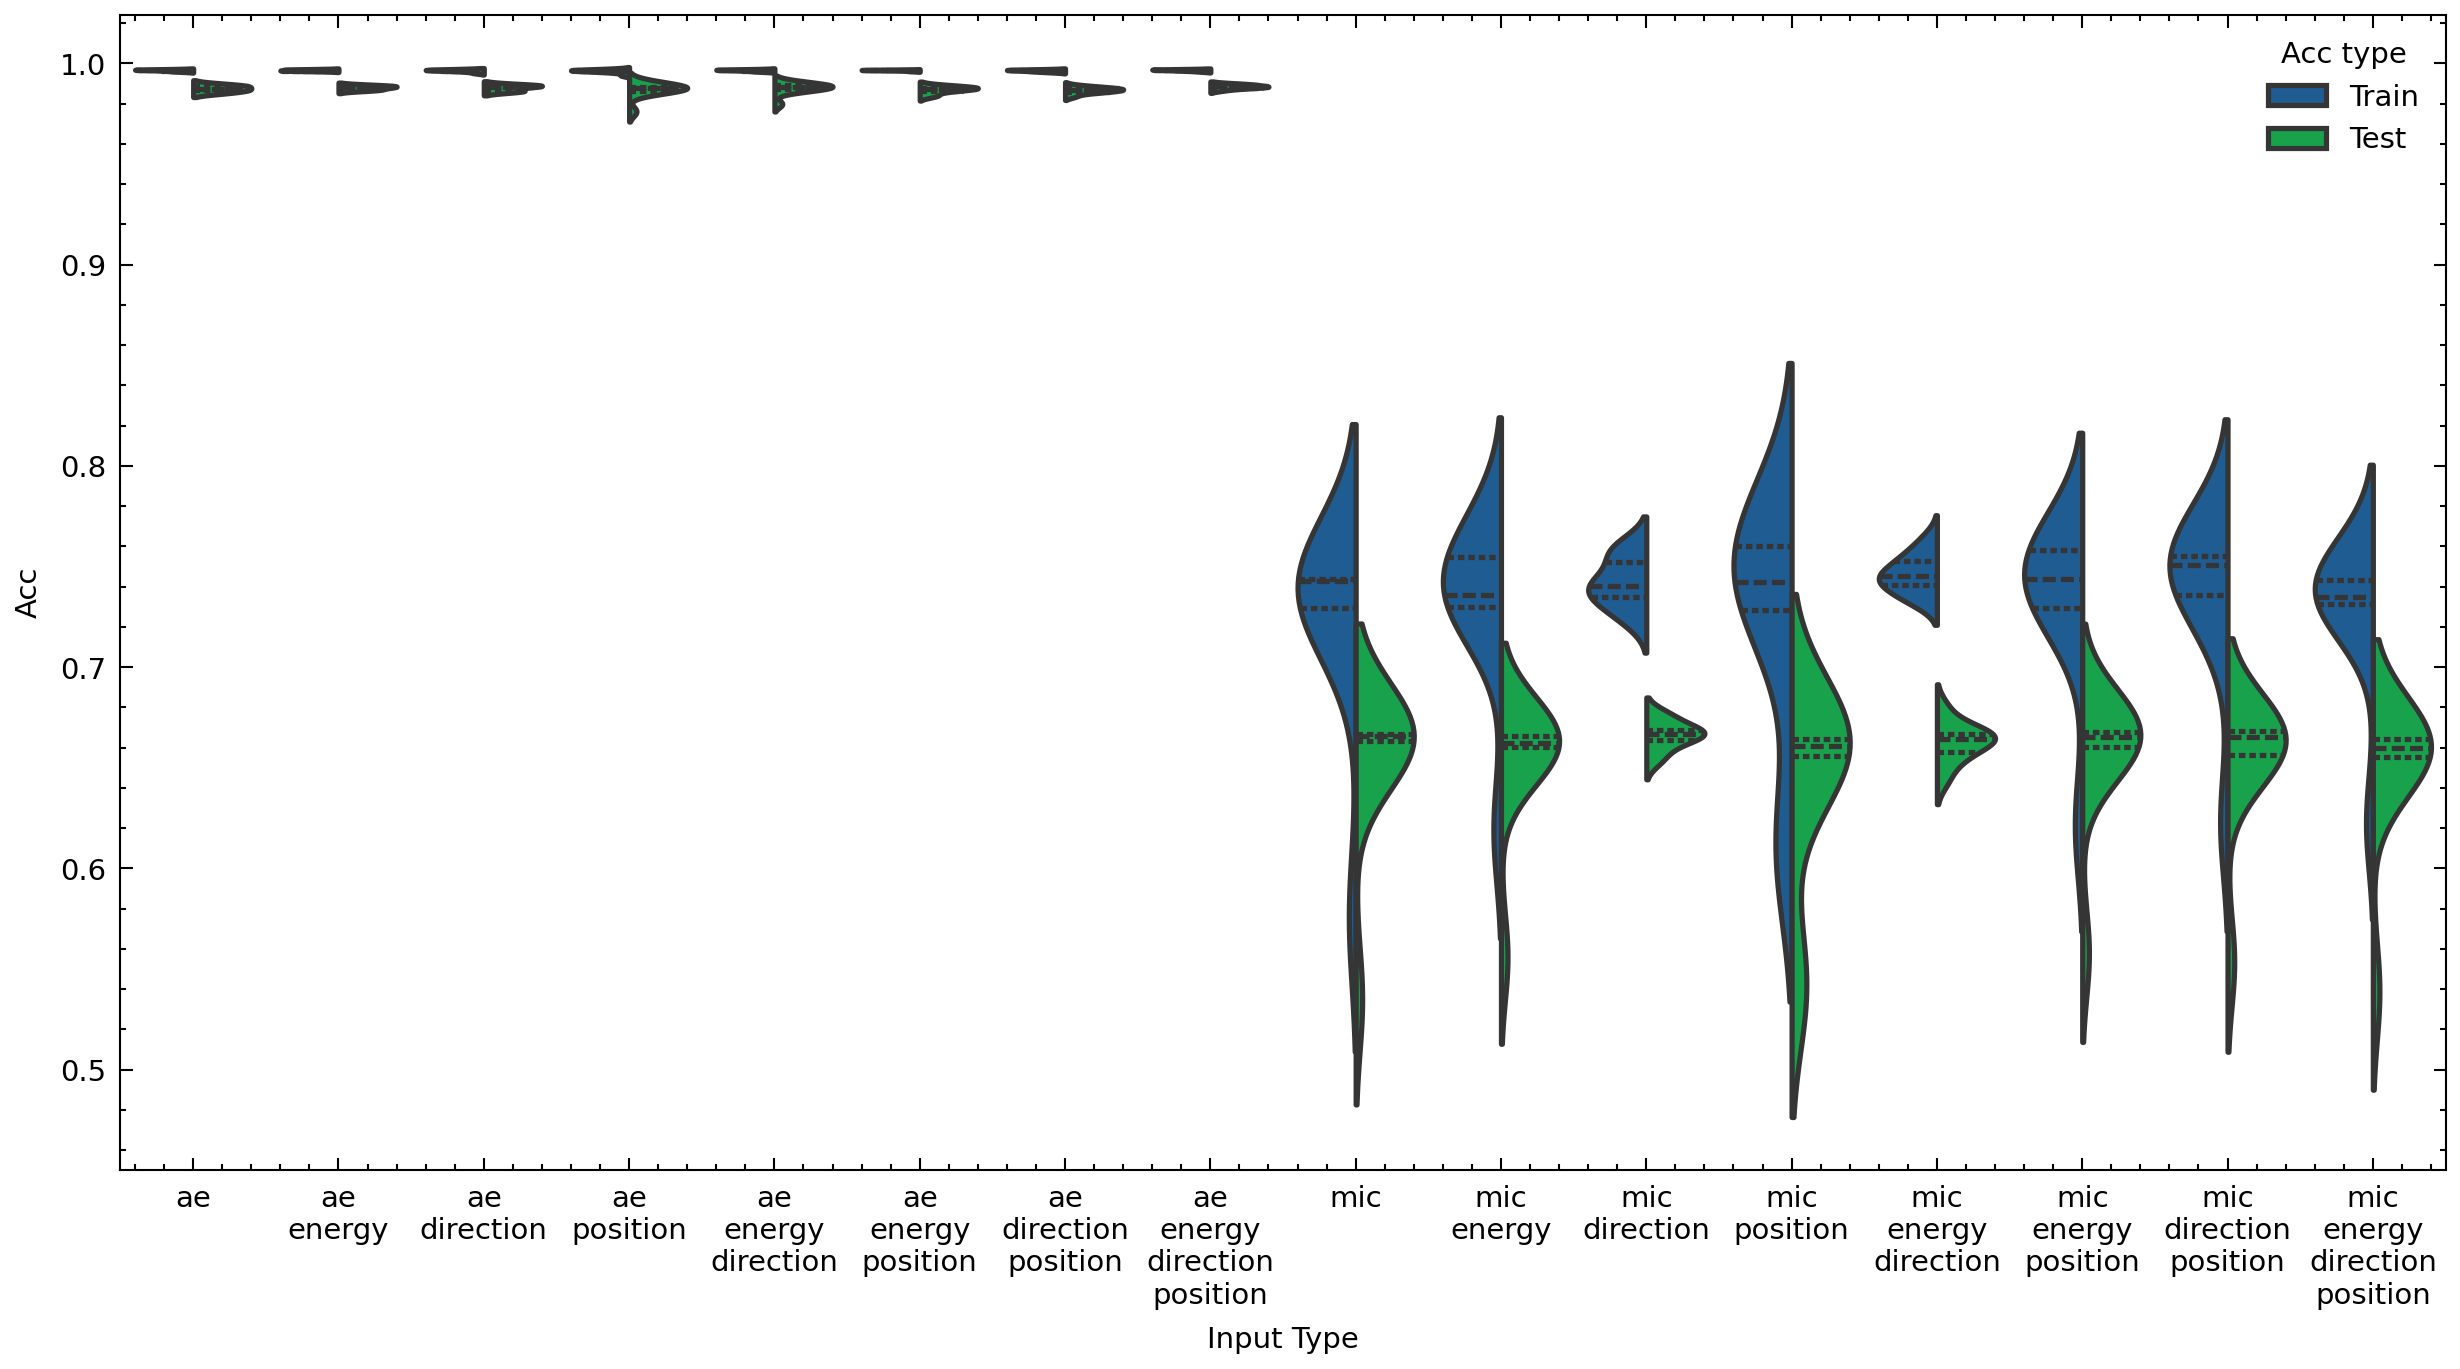

In [177]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[df["Model"]=="CNN"],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

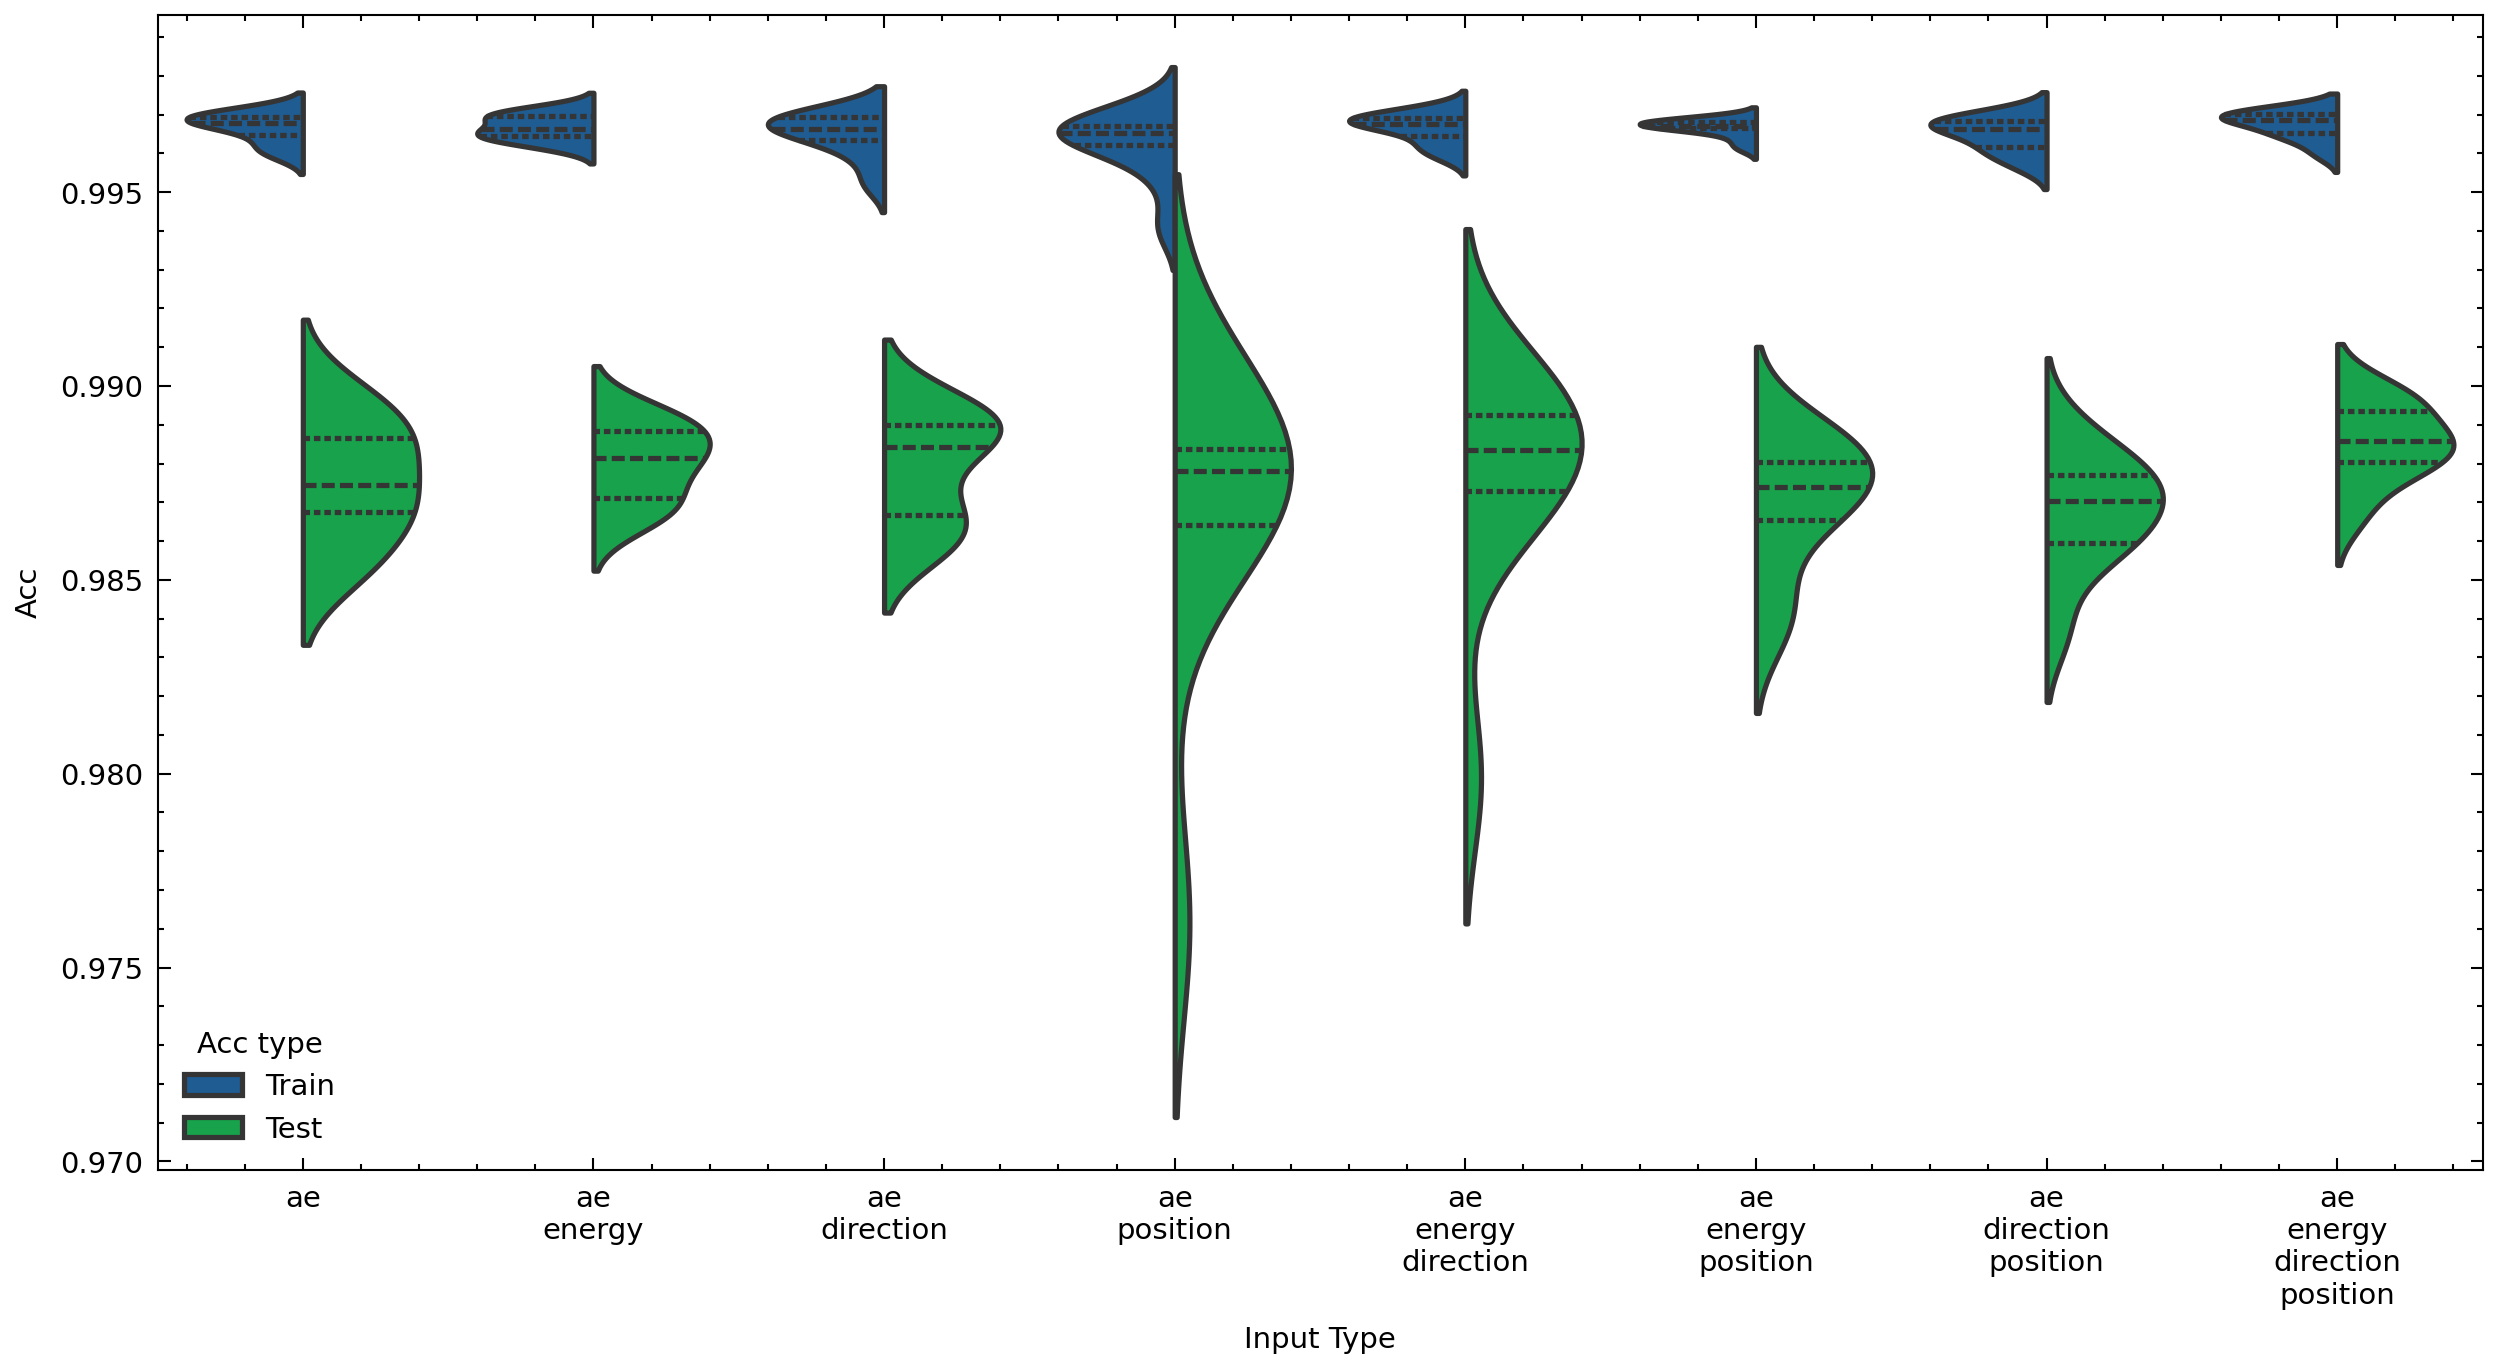

In [176]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[(df["Model"]=="CNN") & df["Input Type"].str.contains("ae")],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

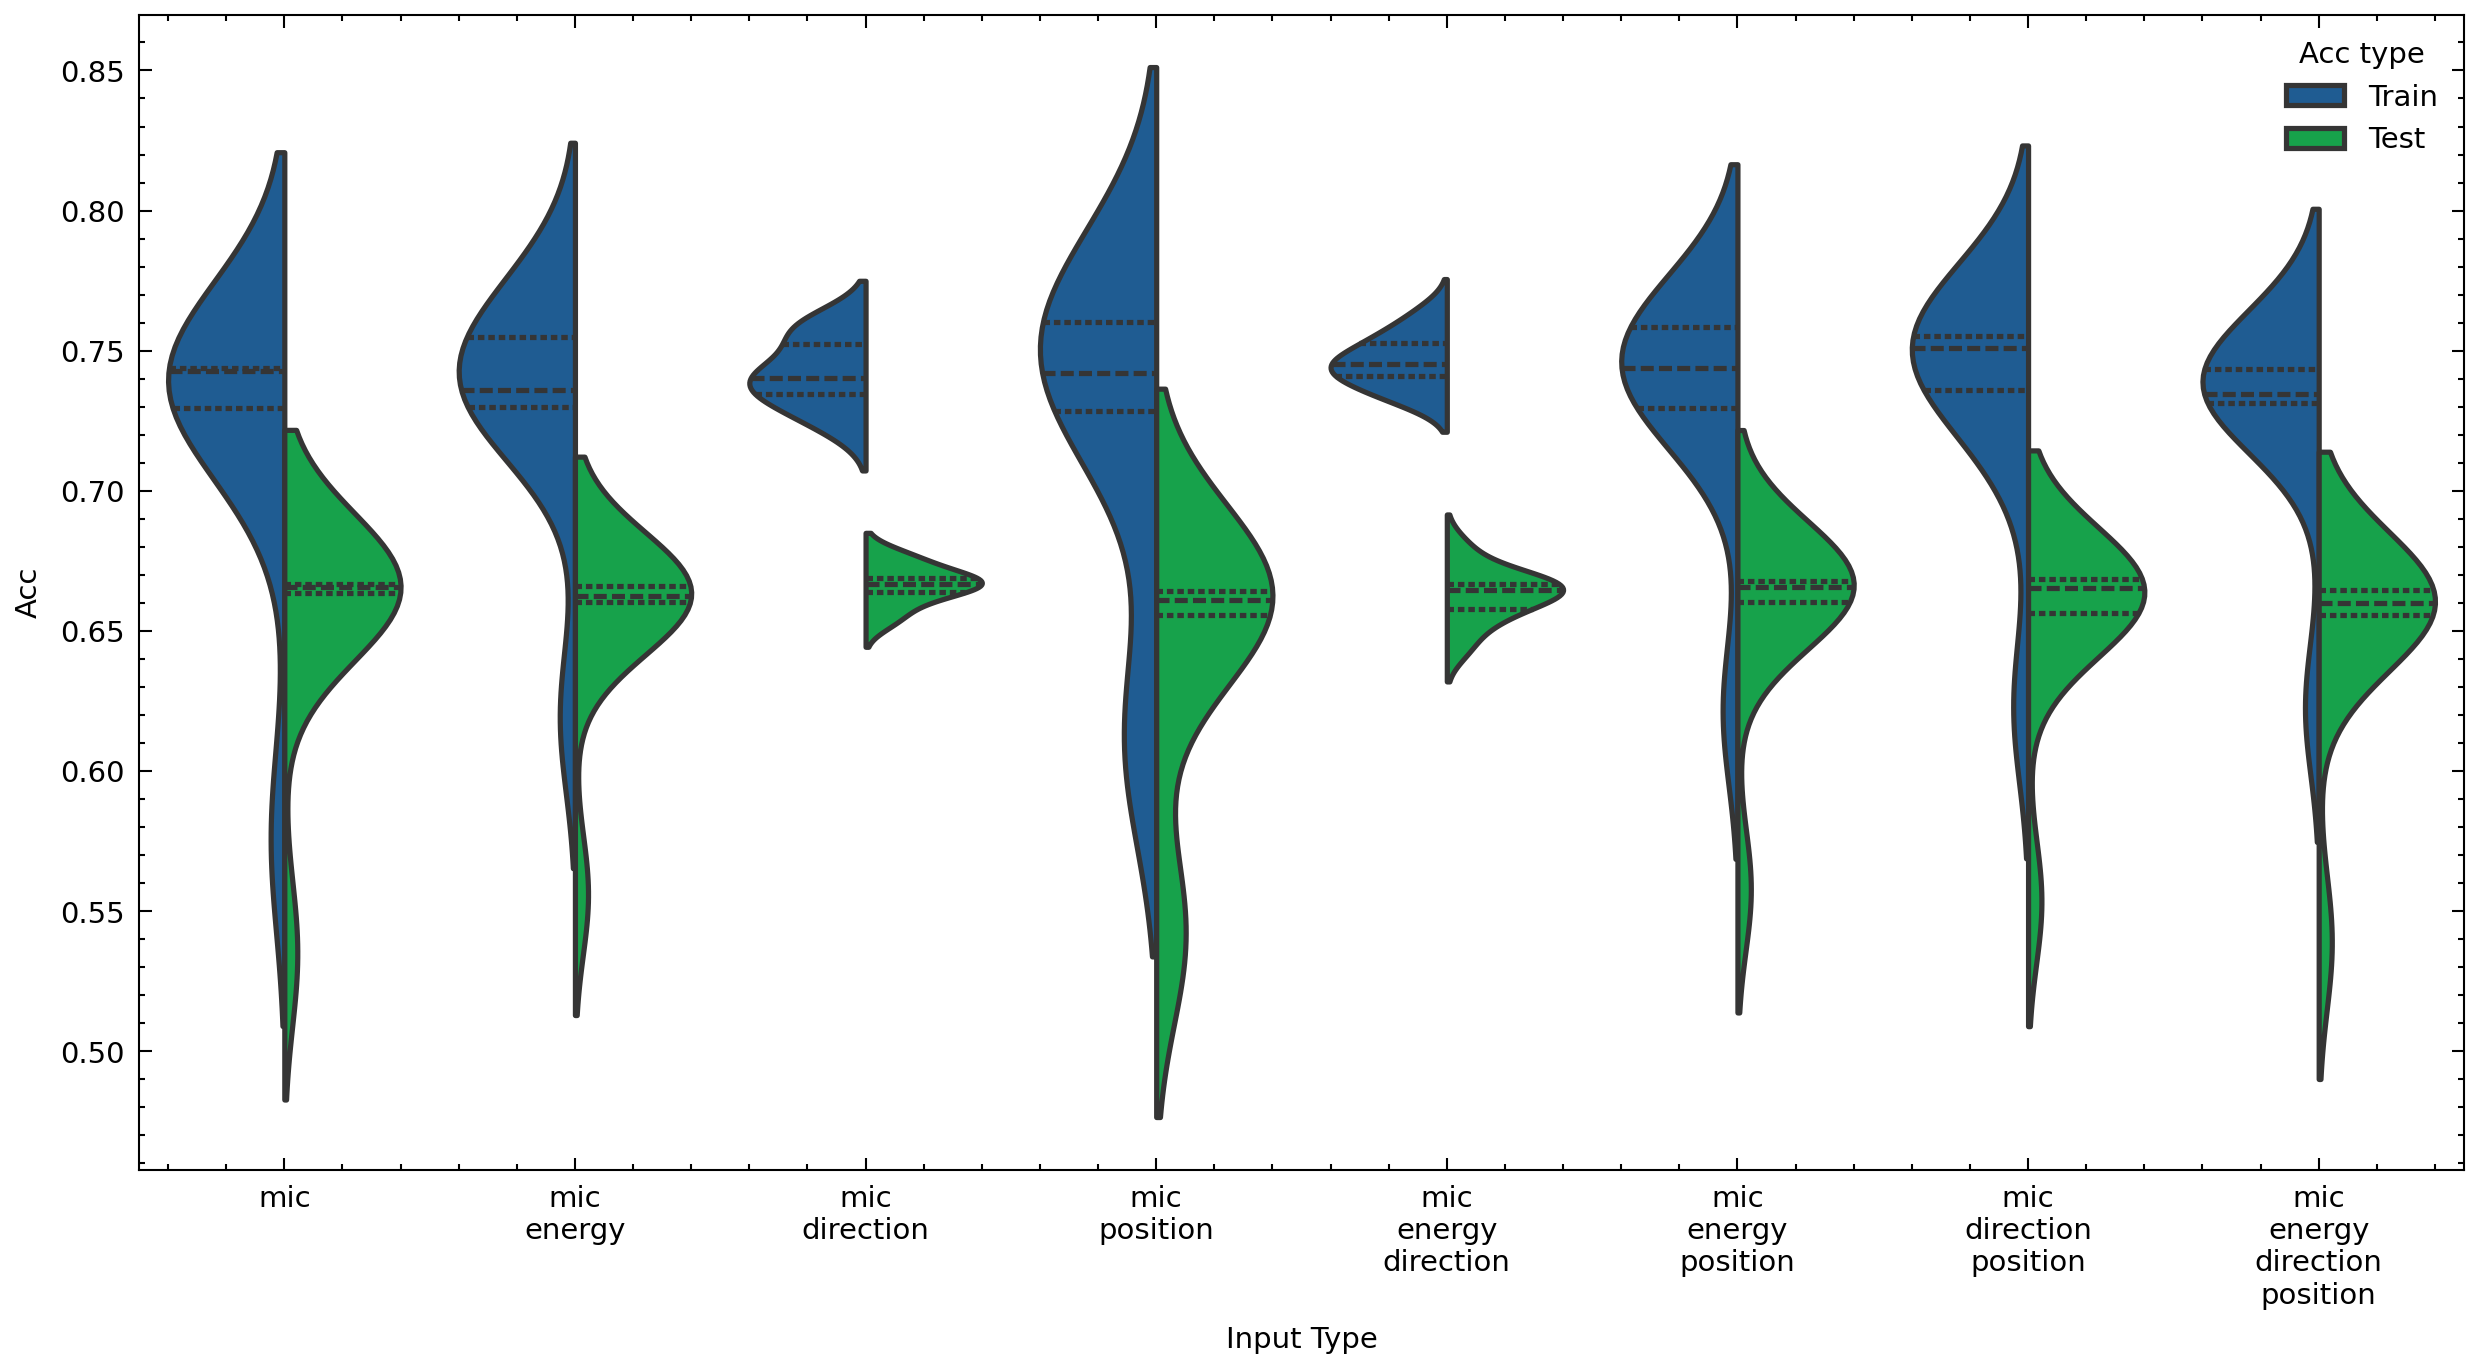

In [175]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[(df["Model"]=="CNN") & df["Input Type"].str.contains("mic")],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

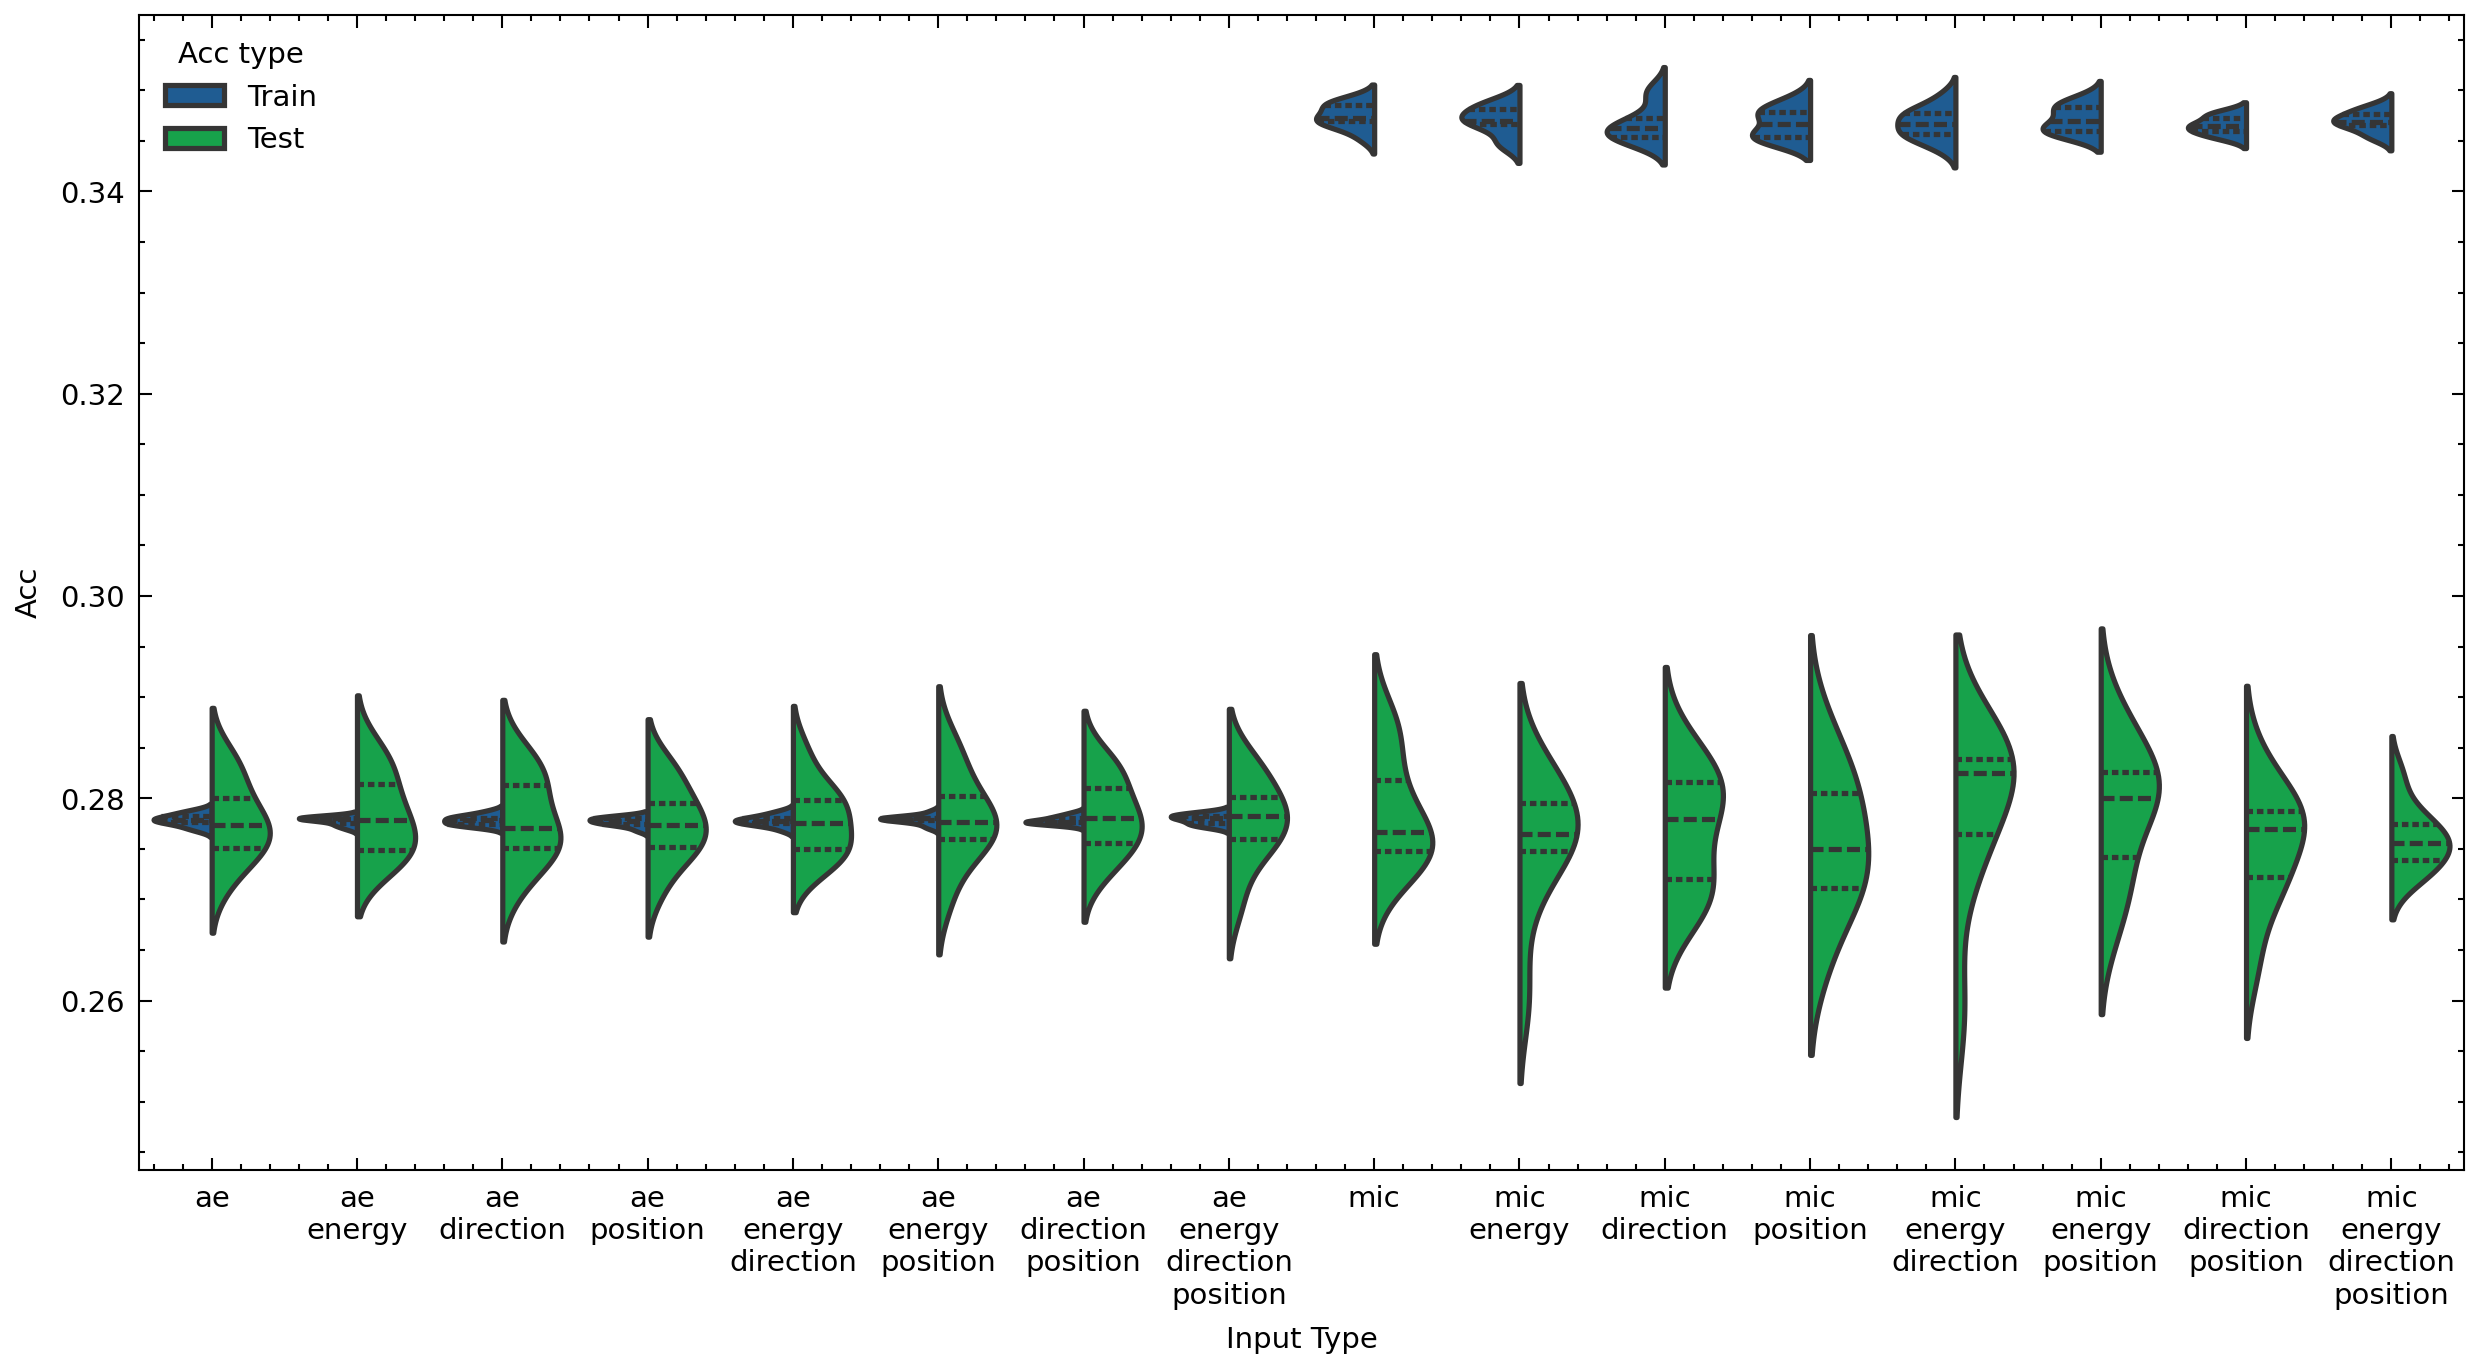

In [178]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[df["Model"]=="SVM"],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

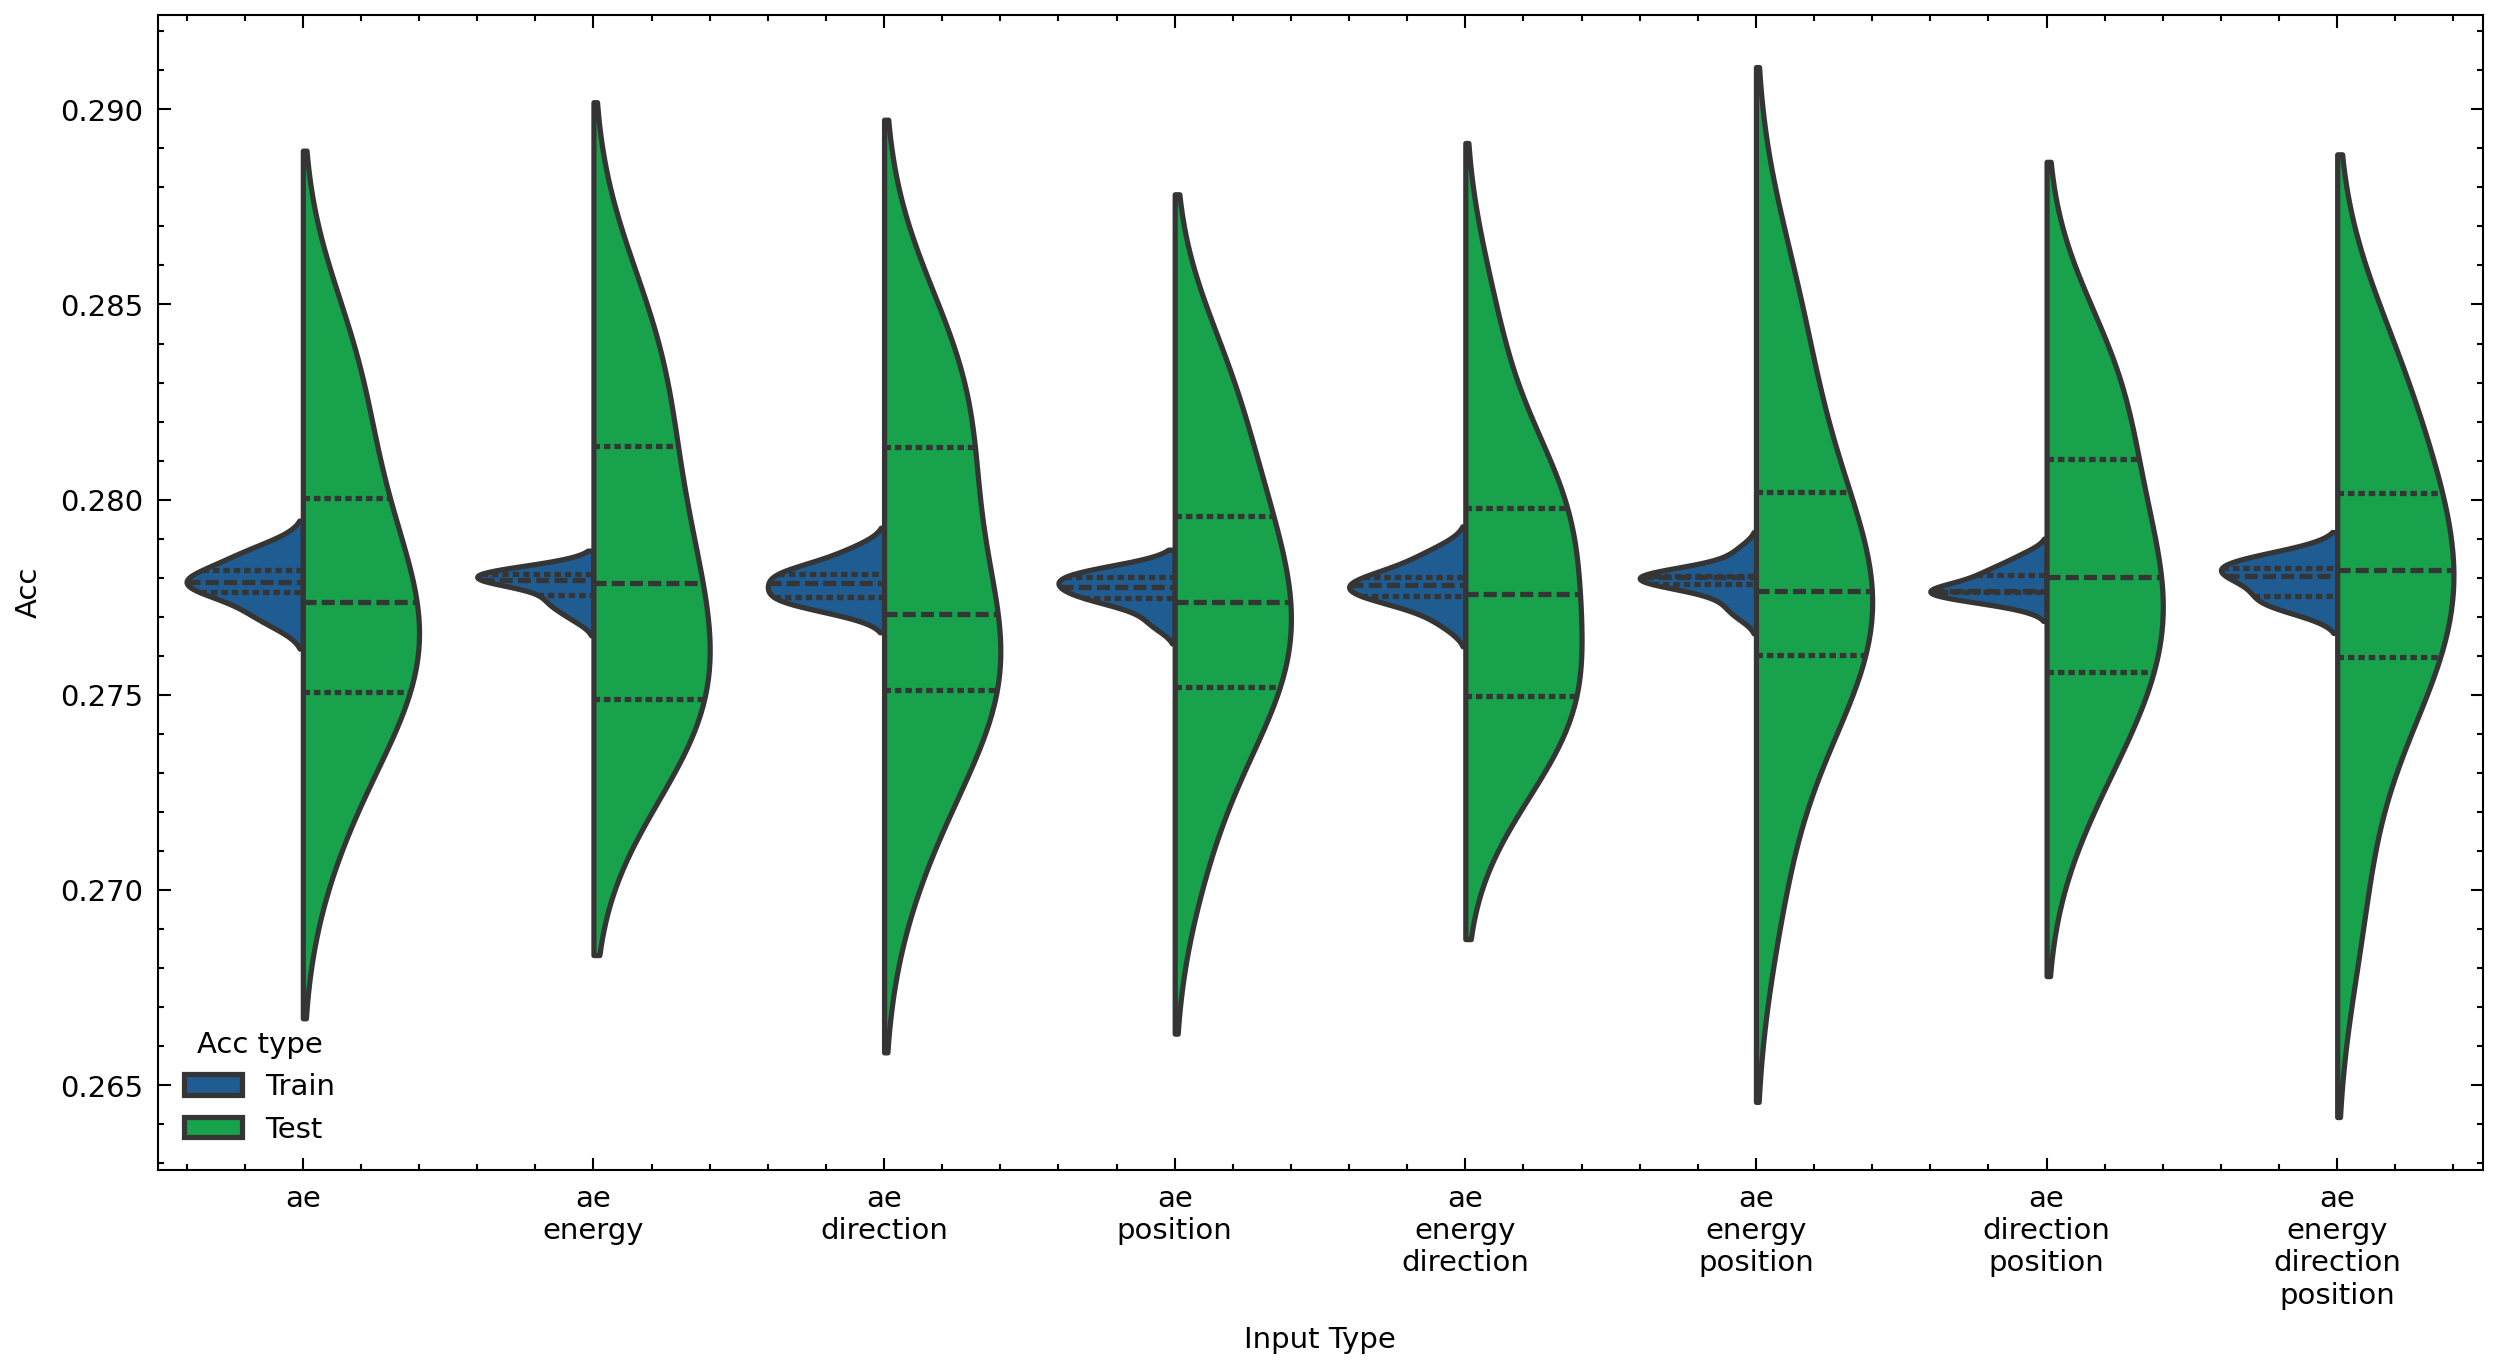

In [179]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[(df["Model"]=="SVM") & df["Input Type"].str.contains("ae")],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

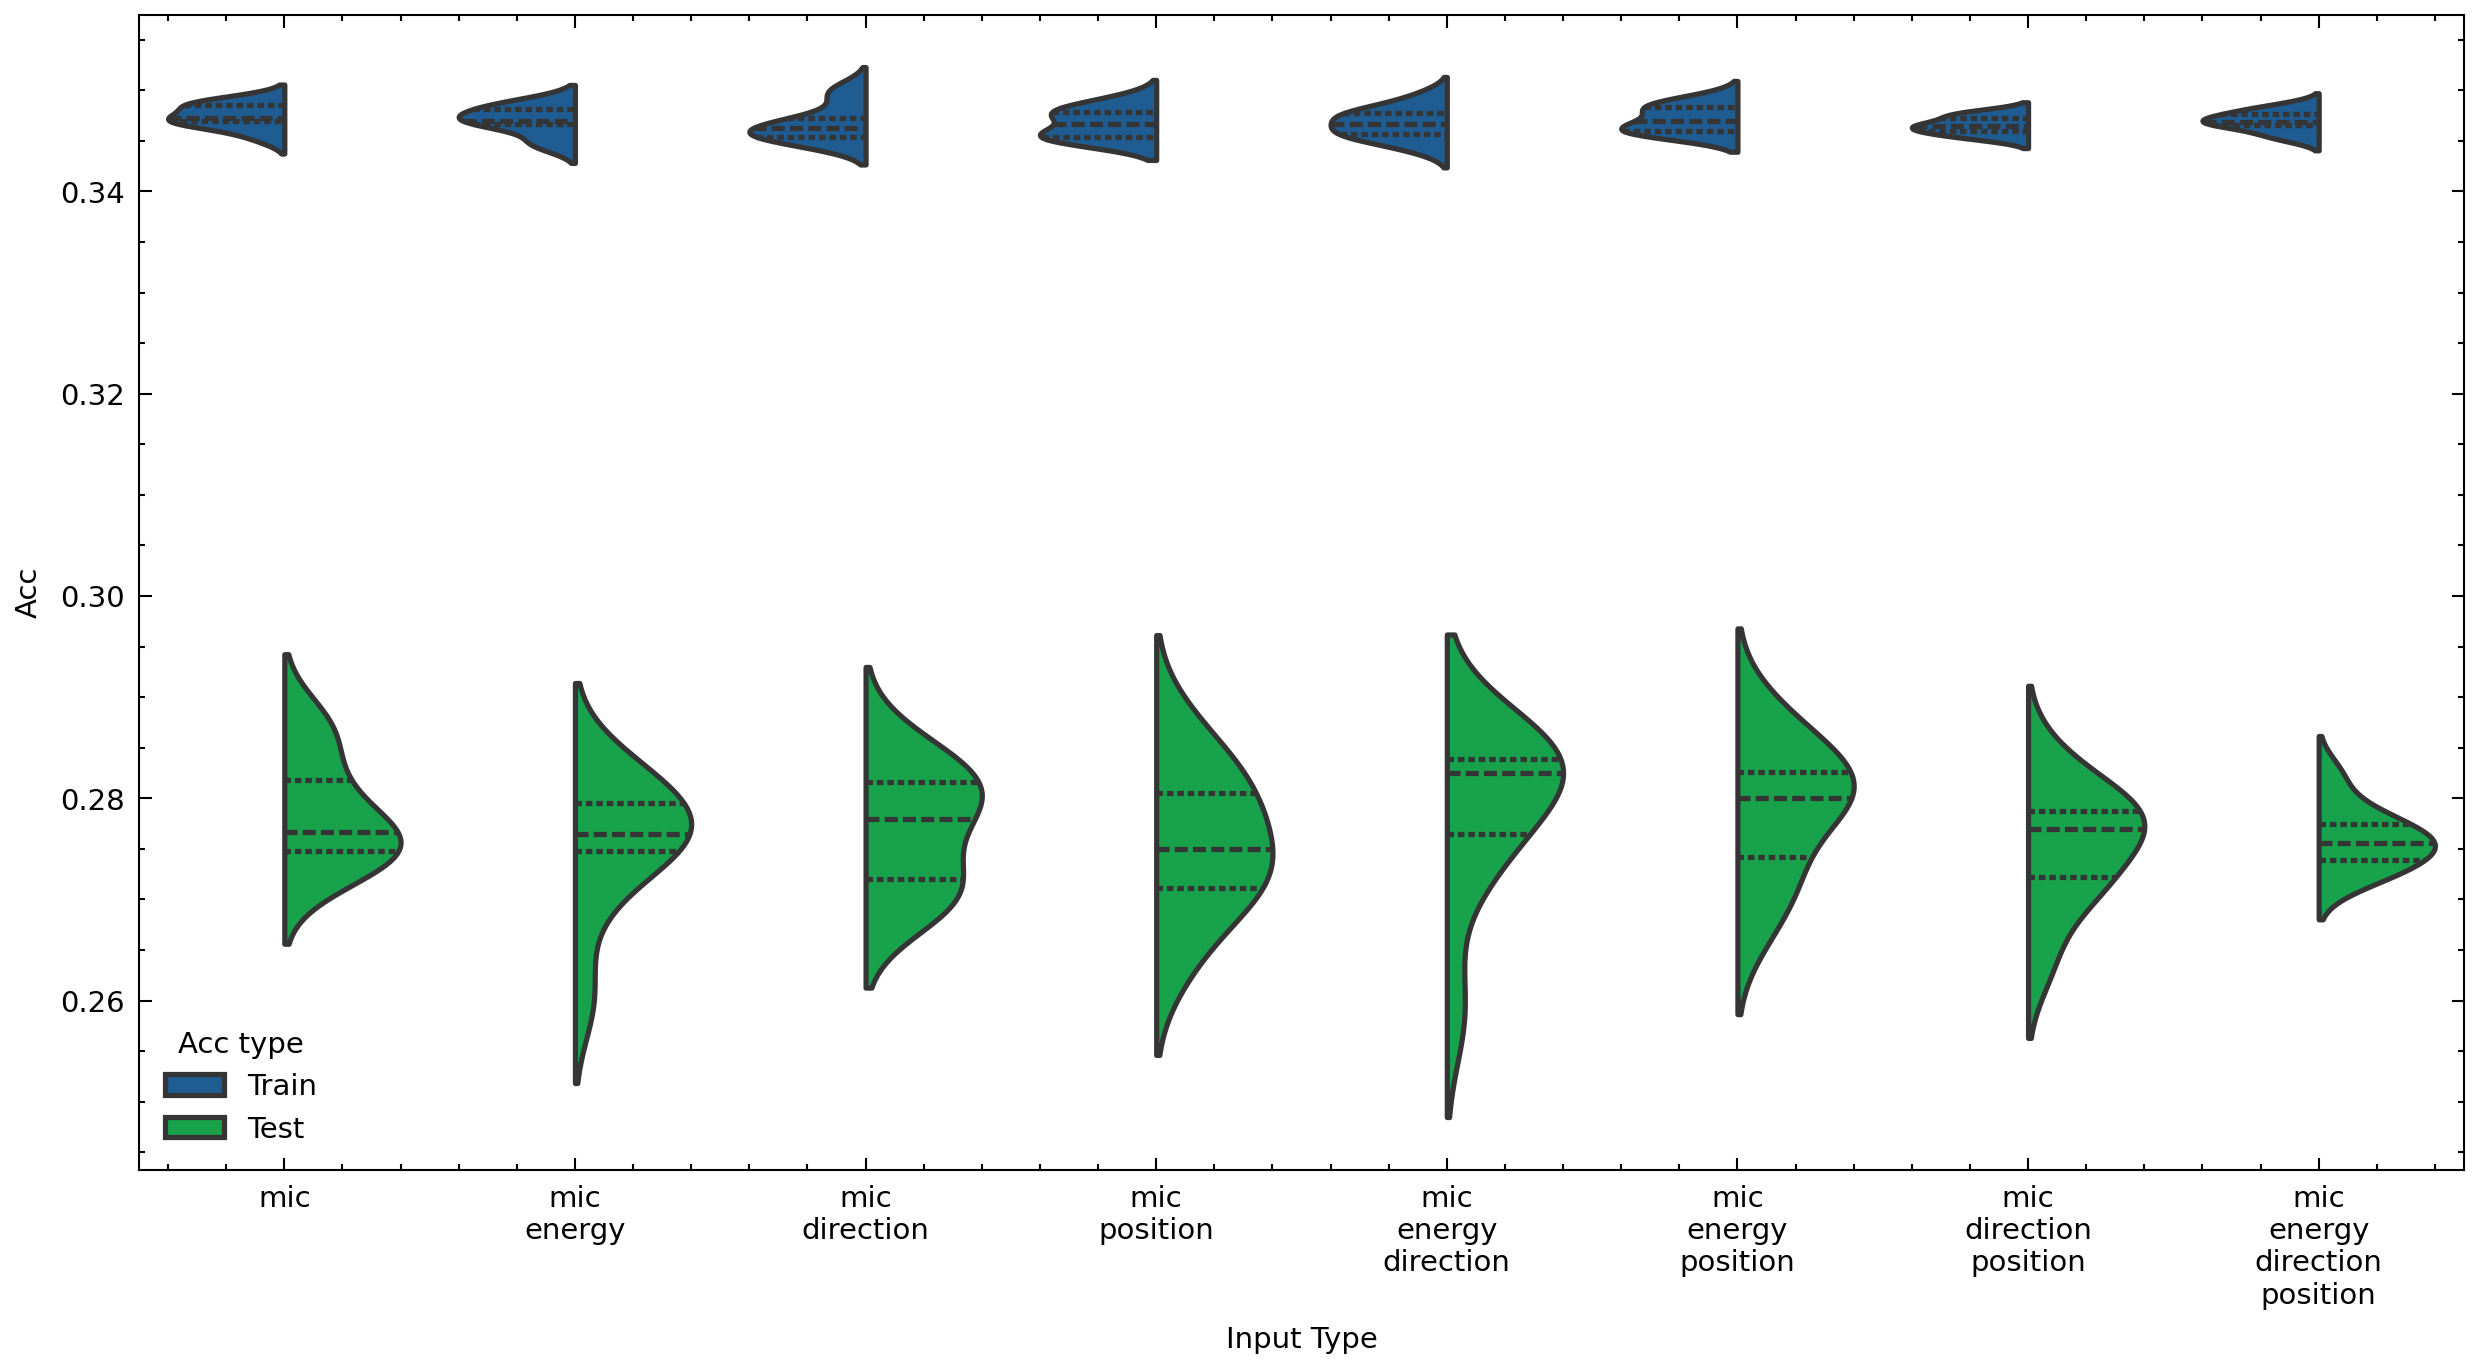

In [180]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[(df["Model"]=="SVM") & df["Input Type"].str.contains("mic")],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)